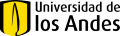

***
# **Competencia: Modelos Avanzados PLN**

***
## Integrantes Equipo 20
- Andrés Felipe Ñungo Fernández
- Andrés Julián Gonzalez Barrera
- Hernando Jose Jimenez Díaz
- Gloria Inés López Urbano

***
# Índice

El *notebook* aborda la competencia con la siguiente estructura:

| 🔹 | Sección        |
|----|----------------|
| 1️.   | **Instalación e importe de librerías** |
...
| 2️.   | **Carga de datos y construcción prompt**  |
...
| 3️. | **Desarrollo del modelo** |
...
| 4️. | **Etapa Entrenamiento**   |
...
| 5️. | **Cargue de los datos de validación**  |

***
# 1. Instalación e importe de librerías

In [1]:
import os
import json
import random
import gc
import time


from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
from datasets import load_dataset
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer
from transformers import logging as hf_logging

hf_logging.set_verbosity_warning()

## 1.1 Definición variables globales y funciones auxiliares

...

In [ ]:
# Parámetros principales

MAX_LENGTH = 1500
GEN_MAX_NEW_TOKENS = 377
BATCH_EVAL = 48

MAX_EVAL_EXAMPLES = None  # None para usar todo eval.json

MODEL_NAME = "Qwen/Qwen3-0.6B-Base"

# Debe coincidir con train.py
OUTPUT_DIR = "output/results/v09"
MODEL_DIR = os.path.join(OUTPUT_DIR, "modfinal")

DATA_PATH = "data/eval/eval.json"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
GLB_SEED = 13

def seed_everything(seed: int = 42, device: str = "cpu") -> None:
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    if device == "cuda":
        torch.cuda.manual_seed_all(seed)


seed_everything(GLB_SEED, DEVICE)

In [ ]:
# Funciones migradas 

def print_time_execution(description, start, end):
    """Devuelve un string con la duración formateada."""
    str_log = ""
    duration = end - start
    if duration > 3600:
        horas = duration // 3600
        minutos = (duration % 3600) // 60
        segundos = duration % 60
        str_log = (
            f"Tiempo {description}: {horas:.0f} horas, "
            f"{minutos:.0f} minutos y {segundos:.2f} segundos"
        )
    elif duration > 60:
        minutos = duration // 60
        segundos = duration % 60
        str_log = f"Tiempo {description}: {minutos:.0f} minutos y {segundos:.2f} segundos"
    else:
        str_log = f"Tiempo {description}: {duration:.6f} segundos"
    return str_log

In [ ]:
def clean_memory():
    "Limpia VRAM agresivamente"
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

***
# 2. Carga y construcción prompt

...

In [ ]:
# Construcción del prompt 
def build_prompt(natural_text: str) -> str:
    instructions = (
        "Eres un extractor de órdenes de compra. Genera SOLO un JSON válido "
        "EXACTAMENTE con los campos requeridos.\n"
        "Reglas:\n"
        "- Usa null cuando un campo no exista.\n"
        '- \"buyer\" debe existir; si name/email/contact/addresses faltan, déjalos en null.\n'
        '- Si addresses está vacío o no existe -> \"addresses\": null.\n'
        '- Si purchases está vacío o no existe -> \"purchases\": null.\n'
        '- shipping es opcional; si falta -> \"shipping\": null.\n'
        "- Asegura que los tipos de datos principales sean correctos "
        "(quantity: entero; country uno de US/CA/GB/ES/CO/DE/FR).\n"
        "- Usa null cuando no tengas información; NO inventes correos, teléfonos "
        "ni códigos de descuento si no aparecen.\n"
        "- Respeta exactamente los nombres de los campos del esquema.\n"
        "- Estructura el problema paso a paso, razona por etapas.\n\n"
    )
    prompt = (
        instructions
        + "Texto:\n"
        + natural_text
        + "\n\nRESPONDE SOLO CON EL JSON VÁLIDO (nada más):\nJSON:\n"
    )
    return prompt

In [ ]:
def extract_json_from_text(text: str):
    """
    Busca el primer '{' y el último '}' y trata de cargarlo como JSON.
    Devuelve:
      - dict/list si se pudo parsear
      - None si no se pudo
    """
    if text is None:
        return None

    start = text.find("{")
    end = text.rfind("}")

    if start == -1 or end == -1 or end <= start:
        return None

    candidate = text[start : end + 1]

    try:
        return json.loads(candidate)
    except Exception:
        return None

In [ ]:
def generate_json_raw_batch(
    texts,
    max_new_tokens: int,
    max_length: int,
    tokenizer,
    model,
    device: str,
):
    """
    Genera salidas del modelo para una lista de textos en lenguaje natural.
    1. Construye el prompt con build_prompt.
    2. Tokeniza con padding/truncation.
    3. Llama a model.generate en modo batch.
    4. Recorta la salida al primer bloque '{...}' si existe.

    Devuelve: lista de strings (uno por texto original).
    """
    # Construir prompts
    prompts = [build_prompt(t) for t in texts]

    enc = tokenizer(
        prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_length,
    )

    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)

    # Tokens especiales
    pad_id = tokenizer.pad_token_id or tokenizer.eos_token_id
    eos_brace_id = tokenizer("}", add_special_tokens=False).input_ids[0]

    with torch.inference_mode():
        model.eval()
        out = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            do_sample=False,  # determinista para evaluación
            pad_token_id=pad_id,
            eos_token_id=eos_brace_id,  # cortar idealmente al cierre del JSON
            use_cache=True,
        )

    decoded = tokenizer.batch_decode(out, skip_special_tokens=True)

    cleaned = []
    for d in decoded:
        if "{" in d and "}" in d:
            first = d.find("{")
            last = d.rfind("}")
            cleaned.append(d[first : last + 1])
        else:
            cleaned.append(d)

    return cleaned


In [ ]:
# Carga de modelo y tokenizer
def load_model_and_tokenizer():
    print("Cargando tokenizer y modelo desde:", MODEL_DIR)

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    dtype = (
        torch.bfloat16
        if (torch.cuda.is_available() and torch.cuda.is_bf16_supported())
        else torch.float16
    )

    # Carga del modelo QLoRA ya entrenado por train.py
    model = AutoPeftModelForCausalLM.from_pretrained(
        MODEL_DIR,
        torch_dtype=dtype,
        device_map="cuda" if DEVICE == "cuda" else "cpu",
        use_cache=True,
    ).eval()

    # Compilación opcional
    try:
        model = torch.compile(model)
    except Exception:
        pass

    return tokenizer, model

***
# 3. Inferencia

...

In [ ]:

# Inferencia por batches
def run_inference(dataset, tokenizer, model):
    all_raw_outputs = []
    n_total = len(dataset)

    print(f"\nGenerando {n_total} predicciones...")
    for i in tqdm(range(0, n_total, BATCH_EVAL), desc="Inferencia"):
        batch_slice = dataset[i : i + BATCH_EVAL]
        batch_texts = batch_slice["natural_language"]

        raw_batch = generate_json_raw_batch(
            texts=batch_texts,
            max_new_tokens=GEN_MAX_NEW_TOKENS,
            max_length=MAX_LENGTH,
            tokenizer=tokenizer,
            model=model,
            device=DEVICE,
        )
        all_raw_outputs.extend(raw_batch)

    return all_raw_outputs

In [ ]:
# Pipeline principal
def main():
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    total_start = time.time() 
    print("Cargando dataset de evaluación y modelo...")
    load_start = time.time()   # <-- INICIO carga modelo/tokenizer
    tokenizer, model = load_model_and_tokenizer()
    load_end = time.time()     # <-- FIN carga modelo/tokenizer
    print(print_time_execution("carga de modelo y tokenizer", load_start, load_end))
    
    dataset = load_dataset("json", data_files=DATA_PATH)["train"]

    # Si quieres probar con un subconjunto
    if MAX_EVAL_EXAMPLES is not None:
        max_n = min(MAX_EVAL_EXAMPLES, len(dataset))
        dataset = dataset.select(range(max_n))

    ids = dataset["id"]

    # 1) Inferencia por batches
    inf_start = time.time()    # <-- INICIO inferencia
    raw_outputs = run_inference(dataset, tokenizer, model)
    inf_end = time.time()      # <-- FIN inferencia
    print(print_time_execution("inferencia sobre eval.json", inf_start, inf_end))

    # Descargar modelo de VRAM
    del model
    clean_memory()

    # 2) Procesar y guardar
    print("\n>>> Procesando resultados y construyendo JSON final...")
    final_predictions = []

    for rec_id, raw in zip(ids, raw_outputs):
        parsed = extract_json_from_text(raw)

        if isinstance(parsed, dict):
            final_json = parsed
        else:
            # En caso de fallo, entrega un JSON vacío (o lo que defina la competencia)
            final_json = {}

        final_predictions.append(
            {
                "id": rec_id,
                "prediction": json.dumps(final_json, ensure_ascii=False),
            }
        )

    df = pd.DataFrame(final_predictions)

    if MAX_EVAL_EXAMPLES is not None:
        csv_path = os.path.join(OUTPUT_DIR, f"submission{MAX_EVAL_EXAMPLES}.csv")
    else:
        csv_path = os.path.join(OUTPUT_DIR, "submission.csv")

    df.to_csv(csv_path, index=False)
    print(f"¡Listo! Archivo guardado en: {csv_path}")

    total_end = time.time()  # <-- FIN tiempo total
    print(print_time_execution("evaluación completa (carga + inferencia + guardado)", total_start, total_end))

In [ ]:
if __name__ == "__main__":
    clean_memory()
    main()

# Celda para estilo de los markdowns (ignorar)

In [7]:
%%html
<!-- Fuentes recomendadas para estilo matemático -->
<link href="https://fonts.googleapis.com/css2?family=STIX+Two+Text:ital,wght@0,400;0,700;1,400;1,700&display=swap" rel="stylesheet">
<link href="https://fonts.googleapis.com/css2?family=STIX+Two+Math:ital,wght@0,400;0,700;1,400;1,700&display=swap" rel="stylesheet">
<link href="https://fonts.googleapis.com/css2?family=Inconsolata:wght@400;700&display=swap" rel="stylesheet">

<style>
  /* --- Markdown clásico (Notebook) --- */
  div.text_cell_render.rendered_html p,
  div.text_cell_render.rendered_html h1,
  div.text_cell_render.rendered_html h2,
  div.text_cell_render.rendered_html h3,
  div.text_cell_render.rendered_html li {
    font-family: 'STIX Two Text', serif !important;
  }

  /* MathJax (fórmulas) */
  .MathJax, .MathJax_Display {
    font-family: 'STIX Two Math', serif !important;
  }

  /* Código */
  div.text_cell_render.rendered_html code,
  div.text_cell_render.rendered_html pre {
    font-family: 'Inconsolata', monospace !important;
  }

  /* --- JupyterLab --- */
  .jp-Notebook .jp-RenderedHTMLCommon p,
  .jp-Notebook .jp-RenderedHTMLCommon h1,
  .jp-Notebook .jp-RenderedHTMLCommon h2,
  .jp-Notebook .jp-RenderedHTMLCommon h3,
  .jp-Notebook .jp-RenderedHTMLCommon li {
    font-family: 'STIX Two Text', serif !important;
  }
  .jp-Notebook .jp-RenderedHTMLCommon code,
  .jp-Notebook .jp-RenderedHTMLCommon pre {
    font-family: 'Inconsolata', monospace !important;
  }
  .jp-Notebook .MathJax,
  .jp-Notebook .MathJax_Display {
    font-family: 'STIX Two Math', serif !important;
  }
</style>